In [1]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
import sympy as sp
from sympy.polys.polyfuncs import interpolate
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

class SMPA(BaseEstimator, ClassifierMixin):
  def __init__(self, learning_rate=0.005, epochs=50, random_state=7, verbose=False, n_points = 3,
              lambda_scaling='log', patience=5, decay_factor=0.5, min_learning_rate=1e-6):
    self.n_points = n_points
    self.learning_rate = learning_rate
    self.epochs = epochs
    self.random_state = random_state
    self.verbose = verbose
    self.lambda_scaling = lambda_scaling
    self.patience = patience
    self.decay_factor = decay_factor
    self.min_learning_rate = min_learning_rate
    self.error_history = []
    self.learning_rate_history = []
    if lambda_scaling not in ['log', 'sqrt', 'none']:
      raise ValueError("lambda_scaling must be from: 'log', 'sqrt', 'none'")
    np.random.seed(random_state)

  def _calculate_means(self, X, y):
    mask_1 = y == 1
    self.m1 = X[mask_1].mean(axis = 0)
    self.m0 = X[~mask_1].mean(axis = 0)
    self.normal_vector = self.m0 - self.m1
    self.reference_point = (self.m0 + self.m1)/2

  def _update_pseudo_labels(self, y):
    m1_displacement = self._calculate_displacement(self.m1.reshape(1, -1))[0]
    self.class_1_pseudo = 1 if m1_displacement > 0 else -1
    self.class_0_pseudo = - self.class_1_pseudo
    return np.where(y == 1, self.class_1_pseudo, self.class_0_pseudo)

  def _generate_spline_points(self, n_points):
    return np.random.uniform(self.X_range[0], self.X_range[1], size = (n_points, self.n_features))

  def _calculate_displacement(self, X):
    """
    Computes the signed distance of each point from the spline.
    """
    displacements = []

    for px, py in X:
        # Define squared distance function
        distance_squared = (self.spline_x - px)**2 + (self.spline_y - py)**2

        # Find t that minimizes distance_squared
        t_closest = minimize_scalar(
            lambda t: distance_squared.subs(self.spline_t, t).evalf(),
            bounds=(0, 1), method='bounded'
        ).x

        # Compute closest point on the spline
        cx, cy = self.spline_x.subs(self.spline_t, t_closest), self.spline_y.subs(self.spline_t, t_closest)

        # Compute normal vector
        dx_dt = sp.diff(self.spline_x, self.spline_t).subs(self.spline_t, t_closest)
        dy_dt = sp.diff(self.spline_y, self.spline_t).subs(self.spline_t, t_closest)
        normal_vector = (-dy_dt, dx_dt)  # Rotate tangent vector

        # Compute vector from closest spline point to (px, py)
        point_vector = (px - cx, py - cy)

        # Compute dot product
        dot_product = normal_vector[0] * point_vector[0] + normal_vector[1] * point_vector[1]

        # Compute signed distance
        signed_distance = np.sqrt(float((px - cx)**2 + (py - cy)**2)) * np.sign(float(dot_product))
        displacements.append(signed_distance)

    return np.array(displacements)

  def _find_spline(self):
    """
    Fits a cubic spline using MPA's internal moving points.
    """
    t = sp.Symbol('t')

    # Sort spline points to ensure continuity
    self.spline_points = self.spline_points[np.argsort(self.spline_points[:, 0])]

    # Separate x and y coordinates
    x_vals = [float(x[0]) for x in self.spline_points]
    y_vals = [float(x[1]) for x in self.spline_points]

    # Generate a polynomial spline
    self.spline_x = interpolate(list(zip(range(len(x_vals)), x_vals)), t)
    self.spline_y = interpolate(list(zip(range(len(y_vals)), y_vals)), t)

    # Store spline parameter variable
    self.spline_t = t

  def plot_spline(self, X, y):
    """
    Plots the dataset and the learned spline.
    """
    # Generate fine t-values for evaluation
    t_vals = np.linspace(-0.1, 3, 100)

    # Compute (x, y) values along the spline
    x_vals = np.array([self.spline_x.subs(self.spline_t, t).evalf() for t in t_vals], dtype=np.float64)
    y_vals = np.array([self.spline_y.subs(self.spline_t, t).evalf() for t in t_vals], dtype=np.float64)

    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k', label="Data Points")

    # Plot original points
    plt.scatter(self.spline_points[:, 0], self.spline_points[:, 1], color='red', label='Spline Control Points')

    # Plot the spline
    plt.plot(x_vals, y_vals, label='Cubic Spline', color='blue')

    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Spline Visualization')
    plt.show()


  def fit(self, X, y):
     self.classes_ = np.unique(y)
     if not set(self.classes_).issubset({0,1}):
        raise ValueError("Labels must be 0 and 1")

     X = np.asarray(X)
     y = np.asarray(y)
     self.n_features = X.shape[1]

    # Store data range for random initialization (still useful for consistency)
     self.X_range = (X.min(axis=0), X.max(axis=0))

     self._calculate_means(X, y)
     self.spline_points = self._generate_spline_points(self.n_points)

     self._find_spline()


In [ ]:
import numpy as np
import sympy as sp
from sympy.polys.polyfuncs import interpolate
from scipy.optimize import minimize_scalar

# Sample data points (for fitting the spline)
x_vals = np.array([-2, -1, 0, 1, 2, 3])
y_vals = np.array([3, 1, 0, 1, 2, 2.5])

# Use sympy to create a smooth spline
x_sym = sp.Symbol('x')
spline = interpolate(list(zip(x_vals, y_vals)), x_sym)

# Convert to a callable function
spline_func = sp.lambdify(x_sym, spline, 'numpy')

def find_closest_point_on_spline(test_point):
    """
    Finds the closest point on the spline to the given test_point.
    """
    x_test, y_test = test_point

    def distance_to_spline(x):
        return (spline_func(x) - y_test)**2 + (x - x_test)**2

    res = minimize_scalar(distance_to_spline, bounds=(min(x_vals), max(x_vals)), method='bounded')
    x_closest = res.x
    y_closest = spline_func(x_closest)
    return x_closest, y_closest

def check_point_side(test_point):
    """
    Determines whether a point is above (+1) or below (-1) the spline.
    """
    x_test, y_test = test_point
    y_spline = spline_func(x_test)
    return 1 if y_test > y_spline else -1

# Test with a random point
test_point = (1.5, 2.2)
closest_point = find_closest_point_on_spline(test_point)
side = check_point_side(test_point)

print(f"Test Point: {test_point}")
print(f"Closest Point on Spline: {closest_point}")
print(f"Point is on {'above' if side == 1 else 'below'} the spline")


Test Point: (1.5, 2.2)
Closest Point on Spline: (1.7601437890640952, 1.8529393712683733)
Point is on above the spline


In [3]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

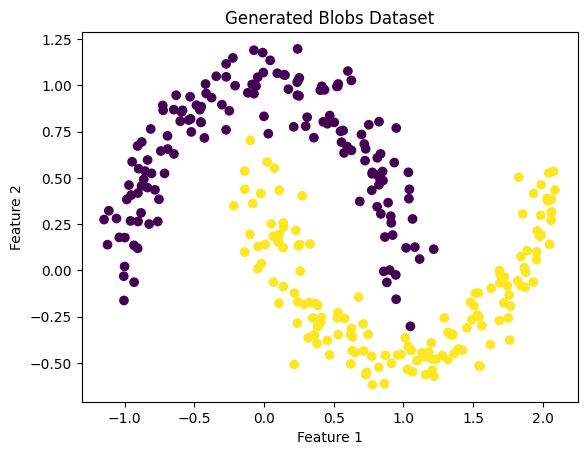

In [4]:
X, y = make_moons(n_samples=300, random_state = 3, noise = 0.1)
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Generated Blobs Dataset")
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 12)

scaler = MinMaxScaler(feature_range=(-100,100))
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.transform(X_test)

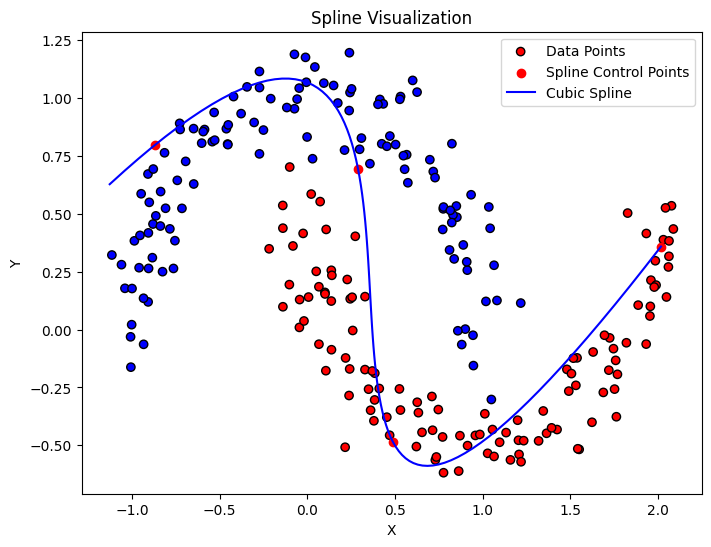

In [5]:
smpa = SMPA(n_points=4)
smpa.fit(X_train, y_train)
smpa.plot_spline(X_train, y_train)

In [6]:
print(smpa.spline_points)

[[-0.8697202   0.79674677]
 [ 0.28993239  0.69430321]
 [ 0.49076933 -0.48778537]
 [ 2.01797449  0.35864864]]


In [7]:
print(smpa.spline_x)
print(smpa.spline_y)

0.380863981942359*t**3 - 1.62199977598224*t**2 + 2.40078838879101*t - 0.869720200488091
0.518027935762791*t**3 - 2.09390631983579*t**2 + 1.4734348250297*t + 0.796746772971764
